In [1]:
!pip install pymorphy2
%load_ext autoreload
%autoreload 2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 33.4 MB/s eta 0:00:00


# Import Libraries

In [2]:
import os
import sys
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.insert(1, '/kaggle/input/ods-huawei/nlp_huawei_new2_task-master/nlp_huawei_new2_task-master/baseline_transformers')
from dataset import *
from model import *
from trainer import Trainer

torch.manual_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
PATH = "/kaggle/input/ods-huawei/"
MAX_LEN = 128
BATCH_SIZE = 64

# Loading data

In [4]:
train_data = pd.read_csv(os.path.join(PATH, "train.csv"))
test_data = pd.read_csv(os.path.join(PATH, "test.csv"))

train_data.head()

rate                                               text
0     4  Очень понравилось. Были в начале марта  с соба...
1     5  В целом магазин устраивает.\nАссортимент позво...
2     5  Очень хорошо что открылась 5 ка, теперь не над...
3     3  Пятёрочка громко объявила о том как она заботи...
4     3  Тесно, вечная сутолока, между рядами трудно ра...

# Label encoding

In [5]:
le = LabelEncoder()

train_data.rate = le.fit_transform(train_data.rate)
train_data.head()

rate                                               text
0     3  Очень понравилось. Были в начале марта  с соба...
1     4  В целом магазин устраивает.\nАссортимент позво...
2     4  Очень хорошо что открылась 5 ка, теперь не над...
3     2  Пятёрочка громко объявила о том как она заботи...
4     2  Тесно, вечная сутолока, между рядами трудно ра...

# EDA

<Axes: ylabel='Frequency'>

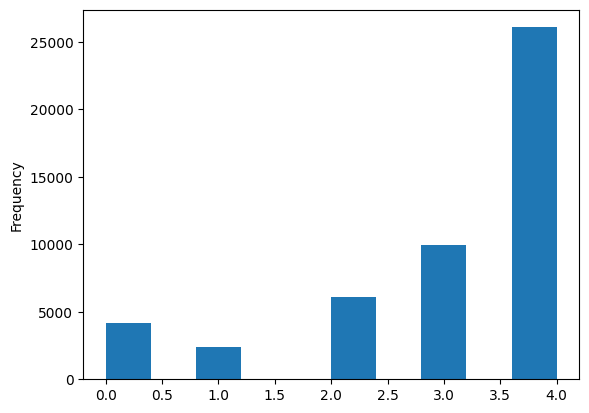

In [6]:
train_data['rate'].plot.hist(grid=False)

# Дисбаланс классов
# попробуем устранить его на этапе моделирования при помощи весо-зависимого лосса

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from string import punctuation

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


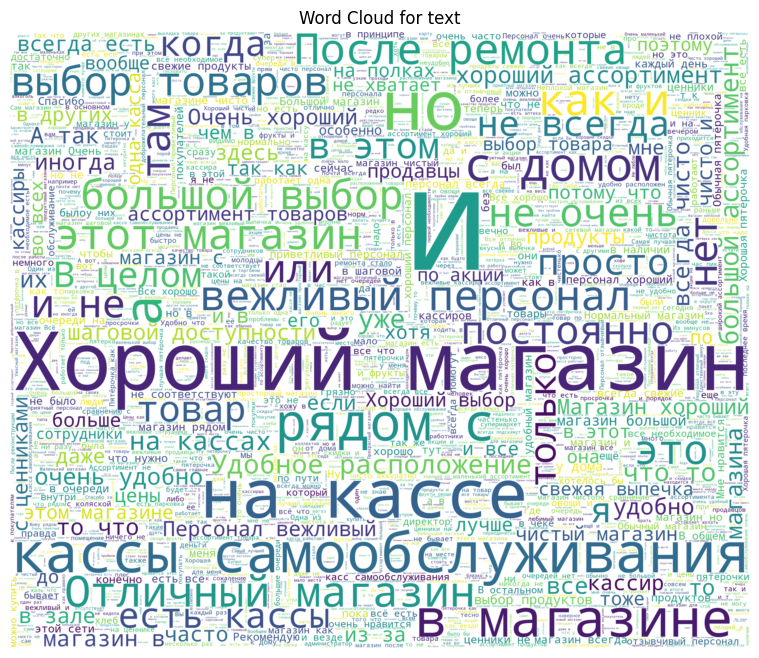

In [8]:
import matplotlib.pyplot as plt
def get_word_cloud(data, text_column, max_words=2000):
    text = ' '.join(data[text_column])
    word_cloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        width=3000,
        height=2500,
        max_words=max_words
    ).generate(text)
    return word_cloud

def display_word_cloud(data, text_column, max_words=2000):
    word_cloud = get_word_cloud(data, text_column, max_words)
    plt.figure(figsize=(10, 8))
    plt.title('Word Cloud for ' + text_column)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
display_word_cloud(train_data, text_column='text')

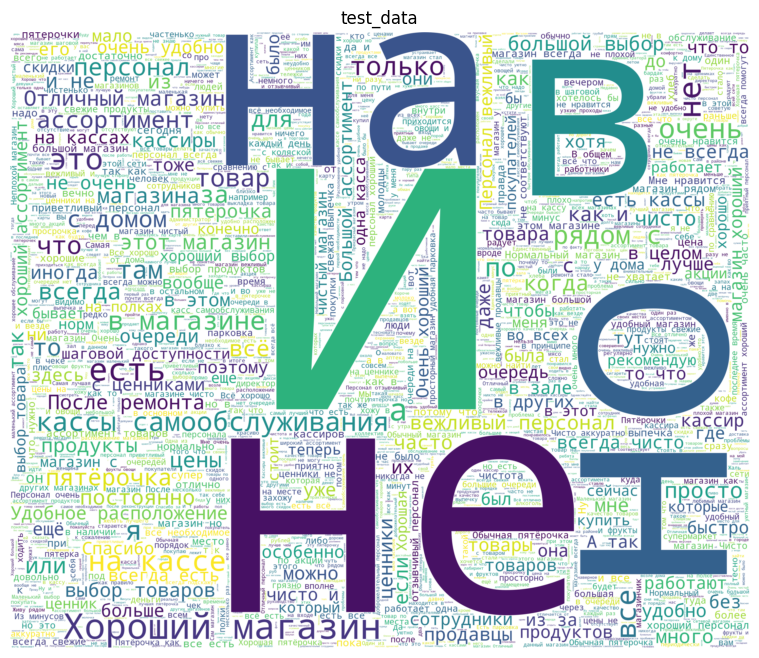

In [9]:
word_cloud = get_word_cloud(test_data, text_column='text')
plt.figure(figsize=(10, 8))
plt.title('test_data')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
# Если чистить, нужно почистить с возможностью сохранения приставок не и слов нет как маркеров отрицания
import re
from nltk.corpus import stopwords
import pymorphy2

TOKEN_RE = re.compile(r'[а-яё]+')
russian_stopwords = set(stopwords.words("russian"))
lemmatizer = pymorphy2.MorphAnalyzer()

def tokenize_text(text, min_length_token=2):
    text = text.lower()
    tokens = TOKEN_RE.findall(text)
    return [token for token in tokens if len(token) >= min_length_token]

def remove_stopwords(tokens):
    return [token for token in tokens if token not in russian_stopwords]

def lemmatize(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(text):
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens)
    return ' '.join(tokens)


In [11]:
from tqdm.notebook import tqdm
tqdm.pandas()
df_token = train_data.copy()
df_token['text'] = df_token['text'].progress_apply(text_cleaning)
df_token.head()

  0%|          | 0/48665 [00:00<?, ?it/s]

rate                                               text
0     3  очень понравиться начало март собака дойти лес...
1     4  целое магазин устраивать ассортимент позволять...
2     4              очень открыться ка далеко ехать рядом
3     2  пятёрочка громко объявить заботиться пенсионер...
4     2  тесно вечный сутолока ряд трудно разойтись гря...

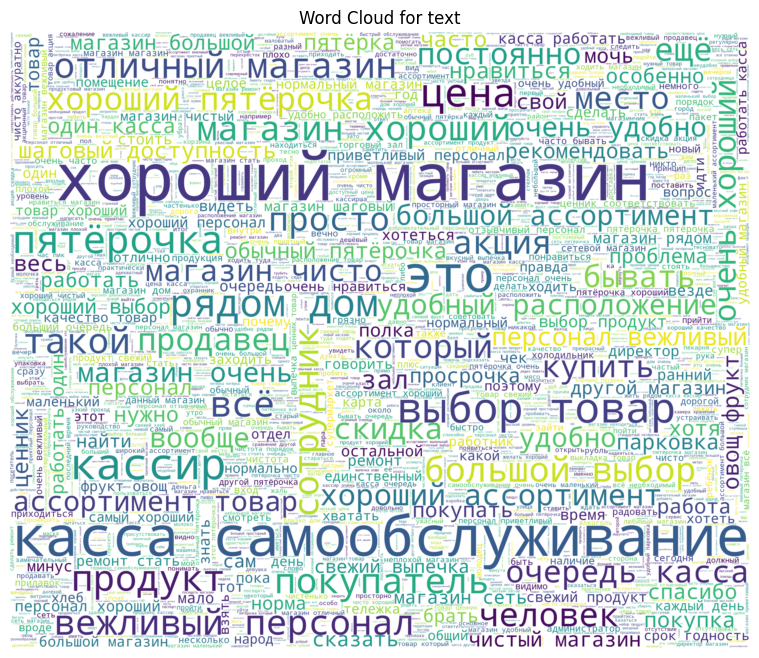

In [12]:
display_word_cloud(df_token, text_column='text')

In [13]:
test_data['text'] = test_data['text'].progress_apply(text_cleaning)

  0%|          | 0/12167 [00:00<?, ?it/s]

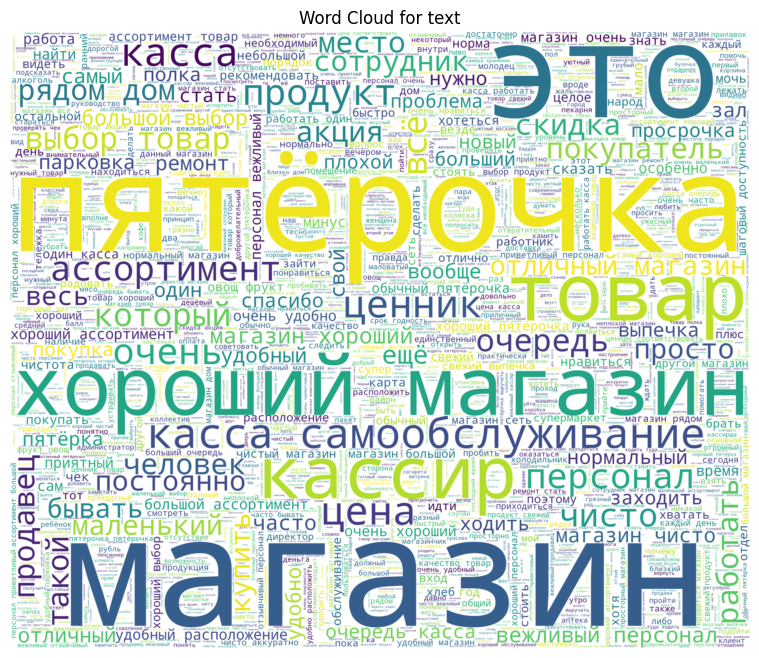

In [14]:
display_word_cloud(test_data, text_column='text')

# Train Test split

In [15]:
train_split, val_split = train_test_split(df_token, test_size=0.25, random_state=42, shuffle = True, stratify=df_token['rate'])

# Loading tokenizer from pretrained

In [16]:
tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

# Creating datasets and dataloaders

In [17]:
train_dataset = FiveDataset(train_split, tokenizer, MAX_LEN)
val_dataset = FiveDataset(val_split, tokenizer, MAX_LEN)
test_dataset = FiveDataset(test_data, tokenizer, MAX_LEN)

In [18]:
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)
test_dataloader = DataLoader(test_dataset, **test_params)

# Loading pretrained model from Huggingface

In [19]:
config = {
    "num_classes": 5,
    "dropout_rate": 0.1
}
model = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=config
)

# Creating Trainer object and fitting the model

# Weighting classes

In [20]:
import numpy as np
def compute_class_weight(train_y):
    """
    Compute class weight given imbalanced training data
    Usually used in the neural network model to augment the loss function (weighted loss function)
    Favouring/giving more weights to the rare classes.
    """
    import sklearn.utils.class_weight as scikit_class_weight

    class_list = list(set(train_y))
    class_weight_value = scikit_class_weight.compute_class_weight(class_weight ='balanced', classes = class_list, y = train_y)
    class_weight = dict()

    # Initialize all classes in the dictionary with weight 1
    curr_max = int(np.max(class_list))
    for i in range(curr_max):
        class_weight[i] = 1

    # Build the dictionary using the weight obtained the scikit function
    for i in range(len(class_list)):
        class_weight[class_list[i]] = class_weight_value[i]

    return class_weight

weights = compute_class_weight(df_token['rate'])

In [21]:
import torch

weight_list = []
for key, weight in weights.items():
    weight_list.append(weight)
weight_tensor = torch.FloatTensor(weight_list)
weight_tensor

tensor([2.3521, 4.0386, 1.5888, 0.9810, 0.3734])

In [22]:
from typing import Dict

import torch
import json
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm.notebook import tqdm

from model import ModelForClassification


class Trainer:
    def __init__(self, config: Dict, class_weights=None):
        self.config = config
        self.device = config['device']
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: Adam(model.parameters(), config['lr'])
        self.model = None
        self.history = None
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
            self.loss_fn = CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = CrossEntropyLoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)
        
    def save_history(self, path: str):
        history = {
            'train_loss': self.history['train_loss'],
            'val_loss': self.history['val_loss'],
            'val_acc': self.history['val_acc']
        }
        with open(path, 'w') as file:
            json.dump(history, file)
        
    def load_history(self, path: str):
        with open(path, 'r') as file:
            history = json.load(file)
        self.history = {
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_acc': history['val_acc']
        }

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])
            self.save_history('history.json')

        return self.model.eval()


    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        print(acc)
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                predictions.extend(outputs.argmax(1).tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    def plot_history(self):
        import matplotlib.pyplot as plt
        
        if self.history is None:
            raise RuntimeError("History is not available. Train the model first.")

        train_loss = self.history['train_loss']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_acc']

        epochs = range(1, len(train_loss) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer

In [23]:
trainer_config = {
    "lr": 3e-4,
    "n_epochs": 10,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
    "verbose": 2,
}
t = Trainer(trainer_config, class_weights=weight_tensor)
t.fit(
    model,
    train_dataloader,
    val_dataloader
)

#0.554

Epoch 1/10


  0%|          | 0/571 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/191 [00:00<?, ?it/s]

0.578860878944397
Epoch 2/10


  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0.5814909338951111
Epoch 3/10


  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0.6022027134895325
Epoch 4/10


  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0.5726966261863708
Epoch 5/10


  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0.55214923620224
Epoch 6/10


  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0.5708062648773193
Epoch 7/10


  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0.5828059315681458
Epoch 8/10


  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0.5636557936668396
Epoch 9/10


  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0.5762308239936829
Epoch 10/10


  0%|          | 0/571 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0.5689159035682678


ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

# Save model

In [24]:
# t.save("first_model.ckpt")
t.save("working_model.ckpt")

# Load pretrained Model

In [25]:
# t = Trainer.load("baseline_model.ckpt")
# t1 = Trainer.load("first_model.ckpt")
# t2 = Trainer.load("second_model.ckpt")
tw = Trainer.load("working_model.ckpt")

# Get testset predictions


In [26]:
# predictions = t.predict(test_dataloader)
# predictions1 = t1.predict(test_dataloader)
# predictions2 = t2.predict(test_dataloader)

# Create submission


In [27]:
# sample_submission = pd.read_csv(os.path.join(PATH, "sample_submission.csv"))
# sample_submission["rate"] = predictions2
# sample_submission.rate = le.inverse_transform(sample_submission.rate)
# sample_submission.head()

In [28]:
# sample_submission.to_csv("submission2.csv", index=False)

# Get train predictions for metrics

In [29]:
train_df = FiveDataset(df_token, tokenizer, MAX_LEN)
df_dataloader = DataLoader(train_df, **test_params)

In [30]:
predictions1 = tw.predict(df_dataloader)

Classification Report for tw:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82      4437
           1       0.76      0.72      0.74      2521
           2       0.80      0.61      0.69      8118
           3       0.65      0.65      0.65      9946
           4       0.83      0.91      0.87     23643

    accuracy                           0.79     48665
   macro avg       0.78      0.74      0.75     48665
weighted avg       0.78      0.79      0.78     48665



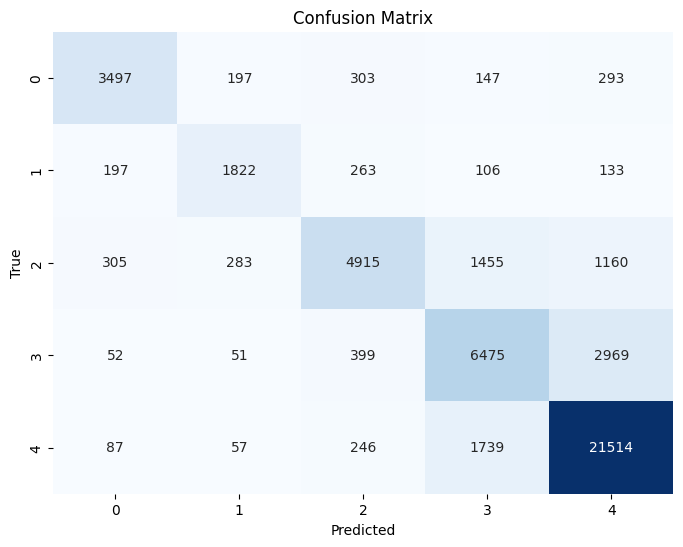

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classification_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# y_true - истинные метки классов
# y_pred - предсказанные метки классов
evaluate_classification_metrics(predictions1, df_token['rate'], "tw")
